In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(46)

In [2]:
# Set a random seed to get same results everytime

def create_dataset():   
    # Create two gaussian matrices for 2 different classes of shape (100x2). 
    X1 = np.random.normal(0.5, 0.3, (100, 2)) # X1 centered at 0.5
    X2 = np.random.normal(-0.5, 0.3, (100, 2)) # X2 centered at -0.5
    y1 = np.array([1] * 100) # y1 with label 1
    y2 = np.array([0] * 100) # y2 with label 0

    # Join both matrices
    X = np.concatenate((X1, X2), axis=0)
    y = np.concatenate((y1, y2))
    return X, y


X-shape: (200, 2)
y-shape: (200,)


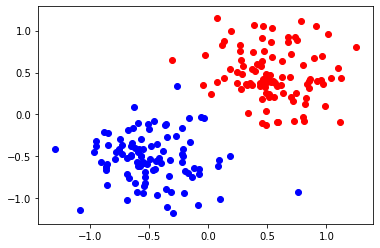

In [3]:
X, y = create_dataset()
print("X-shape: {0}".format(X.shape))
print("y-shape: {0}".format(y.shape))

# Plot to see the data
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='1')
plt.show()

In [4]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        # Learning rate of the model
        self.lr = lr
        # Number of iterations for gradient descent
        self.num_iter = num_iter
        # Whether to fit with the bias term
        self.fit_intercept = fit_intercept
        # If you want to see printed messages
        self.verbose = verbose
        # To store losses for the plot
        self.loss_history = list()
    
    def __add_intercept(self, X):
        # Add the intercept to the data for fitting
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        """
        To generate probabilities, logistic regression uses a function that gives outputs between 0 and 1 
        for all values of X. There are many functions that meet this description, but the used in this case 
        is the logistic or sigmoid function.
        """
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        # Loss function for logistic regression given as below
        # https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization to zero
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            # Theta transpose X
            z = np.dot(X, self.theta)
            # Convert into probabilities by applying sigmoid function
            h = self.__sigmoid(z)
            """
            Our goal is to minimize the loss function and the way we have to achive it is by 
            increasing/decreasing the weights, i.e. fitting them. The question is, how do we know 
            what parameters should be biggers and what parameters should be smallers? 
            The answer is given by the derivative of the loss function with respect to each weight. 
            It tells us how loss would change if we modified the parameters.
            """
            # (h-y) is the error term
            gradient = np.dot(X.T, (h - y)) / y.size
            # The delta change we want to make in the gradient's direction with the learning rate
            self.theta -= self.lr * gradient
            
            # Make the updates 
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            # Calculate the loss 
            loss = self.__loss(h, y)
            # At every 1000th step, append the loss for plotting
            if i % 1000 == 0:
                self.loss_history.append(loss)
                
            if(self.verbose == True and i % 10000 == 0):
                print(f'loss: {loss} \t')
    
    def predict_prob(self, X):
        # Probabilities of predictions
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        # Convert the probablities to (0, 1)
        return self.predict_prob(X).round()
    
    def plot_loss(self):
        # Plot the loss history as a function of number of iterations
        plt.plot(np.array(range(len(self.loss_history))) * 1000, self.loss_history)
        plt.ylabel("Loss")
        plt.xlabel("Number of iterations")
        plt.title("Training loss (Logistic Regression with GD)")
        plt.show()


In [5]:
# Fit the logistic regression model with vanilla gradient descent
# The time taken is approximately 5.5 secs
gd_model = LogisticRegression(lr=0.001, num_iter=100000)
%time gd_model.fit(X, y)

CPU times: user 5.23 s, sys: 99.2 ms, total: 5.33 s
Wall time: 5.85 s


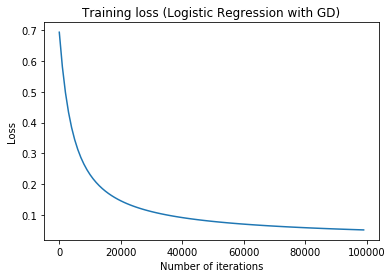

In [6]:
# Plot the training loss
gd_model.plot_loss()

In [7]:
# Predict using the model and calculate the accuracy
preds = gd_model.predict(X)
(preds == y).mean()

0.995

In [8]:
# Check the coefficients
gd_model.theta

array([-0.10871216,  3.90403771,  3.86681202])

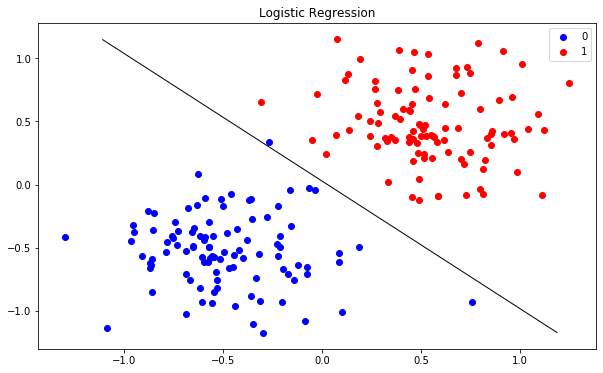

In [17]:
# Plot the classification boundary of our model
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='1')
plt.title("Logistic Regression")
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = gd_model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');

# Logistic Regression with SGD

In [10]:
class LogisticRegressionWithSGD:
    def __init__(self, lr=0.01, epochs=100, batch_size=24, fit_intercept=True, verbose=False):
        # Learning rate of the model
        self.lr = lr
        # Number of iterations for gradient descent
        self.epochs = epochs
        self.batch_size = batch_size
        # Fitting the intercept 
        self.fit_intercept = fit_intercept
        # If you want to see printed messages
        self.verbose = verbose
        # To store losses for the plot
        self.loss_history = list()
    
    def __add_intercept(self, X):
        # Add the intercept to the data for fitting
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        """
        To generate probabilities, logistic regression uses a function that gives outputs between 0 and 1 
        for all values of X. There are many functions that meet this description, but the used in this case 
        is the logistic or sigmoid function.
        """
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, h, y):
        # Loss function for logistic regression given as below
        # https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def __next_batch(self, X, y, batchSize):
        # loop over our dataset `X` in mini-batches of size `batchSize`
        for i in np.arange(0, X.shape[0], batchSize):
            # yield a tuple of the current batched data and labels
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.epochs):   
            epoch_loss_history = list()
            # loop over our data in batches
            for (batchX, batchY) in self.__next_batch(X, y, self.batch_size):
                # Theta transpose X
                z = np.dot(batchX, self.theta)

                # Convert into probabilities by applying sigmoid function
                h = self.__sigmoid(z)
                """
                Our goal is to minimize the loss function and the way we have to achive it is by 
                increasing/decreasing the weights, i.e. fitting them. The question is, how do we know 
                what parameters should be biggers and what parameters should be smallers? 
                The answer is given by the derivative of the loss function with respect to each weight. 
                It tells us how loss would change if we modified the parameters.
                """
                gradient = np.dot(batchX.T, (h - batchY)) / batchY.size
                # The delta change we want to make in the gradient's direction with the learning rate
                self.theta -= self.lr * gradient

                # Make the updates 
                z = np.dot(batchX, self.theta)
                h = self.__sigmoid(z)
                # Calculate the epoch loss and append to epoch loss history
                epoch_loss = self.__loss(h, batchY)
                epoch_loss_history.append(epoch_loss)
            
            self.loss_history.append(np.average(epoch_loss_history))

            if(self.verbose == True and i % 500 == 0):
                print(f'loss: {np.average(epoch_loss_history)} \t')
    
    def predict_prob(self, X):
        # Probabilities of predictions
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X):
        # Convert the probablities to (0, 1)
        return self.predict_prob(X).round()
    
    def plot_loss(self):
        # Plot the loss history as a function of number of epochs
        plt.plot(np.array(range(len(self.loss_history))), self.loss_history)
        plt.ylabel("Loss")
        plt.xlabel("Number of epochs")
        plt.title("Training loss (Logistic Regression with SGD)")
        plt.show()


In [11]:
# Fit the logistic regression model with stochastic gradient descent
# The time taken is approximately 2 secs 
sgd_model = LogisticRegressionWithSGD(lr=0.001, batch_size=32, epochs=5000)
%time sgd_model.fit(X, y)

CPU times: user 1.55 s, sys: 25.3 ms, total: 1.57 s
Wall time: 1.68 s


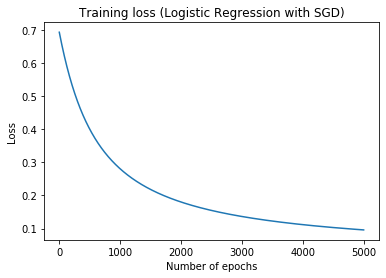

In [12]:
# plot the training loss
sgd_model.plot_loss()

In [13]:
# Predict using the model and calculate the accuracy
preds = sgd_model.predict(X)
(preds == y).mean()

0.995

In [14]:
# Check the coefficients of our model
sgd_model.theta

array([-0.11858113,  2.6344656 ,  2.69258848])

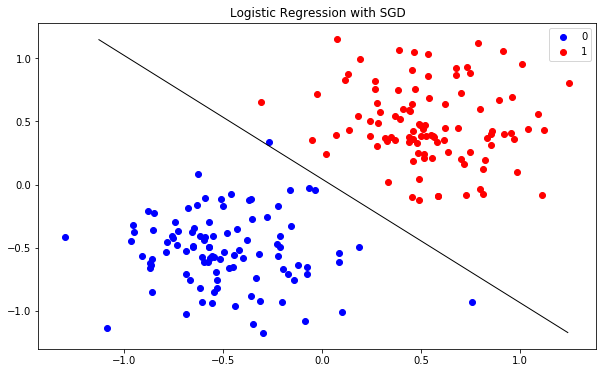

In [16]:
# Plot the classification boundary of our model

plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='1')
plt.title("Logistic Regression with SGD")
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = sgd_model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');